- このnotebookは、元の偉大なnotebookを日本語に翻訳して学びやすくするために作成しました
(This notebook was created to translate the original great notebook into Japanese to make it easier to learn!)
- たまに、上記カーネル以外にも日本語で適宜補足解説を加えています
(Occasionally, supplementary explanations are added in Japanese.)
- upvoteはこのnotebookではなく[元のnotebook](https://www.kaggle.com/phunghieu/connectx-with-deep-q-learning)にお願いします
(Please upvote to [original great notebook](https://www.kaggle.com/phunghieu/connectx-with-deep-q-learning), not this notebook. Thanks!)

# About Reinforcement Learning and Deep Q-Learning

強化学習とは、報酬を最大化するために、環境の中から特定の状態で特定の行動を取るようにエージェントを訓練することに重点を置いた機械学習の一分野である。<BR>
DQN(Deep Q-Net)は、エージェントが各状態で取ることができる行動を見つけるために深層学習モデルを構築する強化学習アルゴリズムです。
> "Reinforcement learning is an area of machine learning that is focused on training agents to take certain actions at certain states from within an environment to maximize rewards. DQN (Deep Q-Net) is a reinforcement learning algorithm where a deep learning model is built to find the actions an agent can take at each state." [*Siwei Xu's tutorial
*](https://towardsdatascience.com/deep-reinforcement-learning-build-a-deep-q-network-dqn-to-play-cartpole-with-tensorflow-2-and-gym-8e105744b998)

<a class="anchor" id="ToC"></a>
# Table of Contents
1. [Install libraries](#install_libraries)
1. [Import libraries](#import_libraries)
1. [Define useful classes](#define_useful_classes)
1. [Define helper-functions](#define_helper_functions)
1. [Create ConnectX environment](#create_connectx_environment)
1. [Configure hyper-parameters](#configure_hyper_parameters)
1. [Train the agent](#train_the_agent)
1. [Save weights](#save_weights)
1. [Create an agent](#create_an_agent)
1. [Evaluate the agent](#evaluate_the_agent)

<a class="anchor" id="install_libraries"></a>
# Install libraries
[Back to Table of Contents](#ToC)

- kaggleが用意してくれてる強化学習用の環境
- 公式(https://github.com/Kaggle/kaggle-environments) には以下のように書いてあります

> Kaggle Environments was created to evaluate episodes. While other libraries have set interface precedents (such as Open.ai Gym), the emphasis of this library focuses on:
> Episode evaluation (compared to training agents).
> Configurable environment/agent lifecycles.
> Simplified agent and environment creation.
> Cross language compatible/transpilable syntax/interfaces.

特に「エピソードの評価」や「エージェントや環境の作成をシンプルに」することを意図して作られているようです。<BR>また、他のインターフェース（openai.gymなど）との互換性も意識しているようです。

In [1]:
# !pip install 'kaggle-environments==0.1.6' > /dev/null 2>&1

<a class="anchor" id="import_libraries"></a>
# Import libraries
[Back to Table of Contents](#ToC)

In [2]:
import numpy as np
import gym
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from kaggle_environments import evaluate, make

<a class="anchor" id="define_useful_classes"></a>
# Define useful classes

このnotebookでは、[*Siwei Xu's さんのtutorial*](https://towardsdatascience.com/deep-reinforcement-learning-build-a-deep-q-network-dqn-to-play-cartpole-with-tensorflow-2-and-gym-8e105744b998)の内容をベースにNNを組んでいます

> NOTE: I use the neural network in [*Siwei Xu's tutorial
> *](https://towardsdatascience.com/deep-reinforcement-learning-build-a-deep-q-network-dqn-to-play-cartpole-with-tensorflow-2-and-gym-8e105744b998) with some proper modifications to adapt to the problem in ConnectX competition and be able to save trained and load pre-trained models.
> 


[Back to Table of Contents](#ToC)

ConnectXの環境作り。
基本的なメソッドについては、こちらの[Qiita記事](https://qiita.com/ishizakiiii/items/75bc2176a1e0b65bdd16)がわかりやすいと思います

In [3]:
# 基本的なConnectXの環境作成クラス

class ConnectX(gym.Env):
    def __init__(self, switch_prob=0.5):
        self.env = make('connectx', debug=False)
        self.pair = [None, 'random']
        self.trainer = self.env.train(self.pair)
        self.switch_prob = switch_prob

        # Define required gym fields (examples):
        config = self.env.configuration
        self.action_space = gym.spaces.Discrete(config.columns) #アクションを行う範囲（離散値：7）
        self.observation_space = gym.spaces.Discrete(config.columns * config.rows) #取り得る状態（6行7列=42）

    def switch_trainer(self):
        self.pair = self.pair[::-1]
        self.trainer = self.env.train(self.pair)

    def step(self, action):
        return self.trainer.step(action)
    
    def reset(self):
        if np.random.random() < self.switch_prob:
            self.switch_trainer()
        return self.trainer.reset()
    
    def render(self, **kwargs):
        return self.env.render(**kwargs)
    

In [4]:
# ネットワークの構築クラス
# Inputは（バッチサイズ（行） × 状態（42列））、outputは（バッチサイズ（行） × 行動（7列））

class DeepModel(tf.keras.Model):
    def __init__(self, num_states, hidden_units, num_actions):
        super(DeepModel, self).__init__()
        self.input_layer = tf.keras.layers.InputLayer(input_shape=(num_states,))
        self.hidden_layers = []
        for i in hidden_units:
            self.hidden_layers.append(tf.keras.layers.Dense(
                i, activation='sigmoid', kernel_initializer='RandomNormal'))
        self.output_layer = tf.keras.layers.Dense(
            num_actions, activation='linear', kernel_initializer='RandomNormal')

#     @tf.function
    def call(self, inputs):
        z = self.input_layer(inputs)
        for layer in self.hidden_layers:
            z = layer(z)
        output = self.output_layer(z)
        return output


- このカーネルの肝になるDQNクラス

In [5]:
class DQN:
    def __init__(self, num_states, num_actions, hidden_units, gamma, max_experiences, min_experiences, batch_size, lr):
        self.num_actions = num_actions
        self.batch_size = batch_size
        self.optimizer = tf.optimizers.Adam(lr)
        self.gamma = gamma
        self.model = DeepModel(num_states, hidden_units, num_actions)
        self.experience = {'s': [], 'a': [], 'r': [], 's2': [], 'done': []} # The buffer
        self.max_experiences = max_experiences
        self.min_experiences = min_experiences

    def predict(self, inputs):
        # stateから行動を予測。batch sizeのstateもsingle stateにも対応するためにnp.atleast_2dを利用
        # np.atleast_2d:[1, -1]にreshapeするやつ
        # arr = np.arange(0, 5) print(np.atleast_2d(arr)) [[0 1 2 3 4]]
        return self.model(np.atleast_2d(inputs.astype('float32')))

#     @tf.function
    def train(self, TargetNet):
        if len(self.experience['s']) < self.min_experiences:
            # Only start the training process when we have enough experiences in the buffer
            return 0

        # Randomly select n experience in the buffer, n is batch-size
        ids = np.random.randint(low=0, high=len(self.experience['s']), size=self.batch_size)
        states = np.asarray([self.preprocess(self.experience['s'][i]) for i in ids])
        actions = np.asarray([self.experience['a'][i] for i in ids])
        rewards = np.asarray([self.experience['r'][i] for i in ids])

        # Prepare labels for training process
        states_next = np.asarray([self.preprocess(self.experience['s2'][i]) for i in ids])
        dones = np.asarray([self.experience['done'][i] for i in ids])
        value_next = np.max(TargetNet.predict(states_next), axis=1)
        actual_values = np.where(dones, rewards, rewards+self.gamma*value_next)
        
        # 損失関数の定義
        with tf.GradientTape() as tape:
            selected_action_values = tf.math.reduce_sum(
                self.predict(states) * tf.one_hot(actions, self.num_actions), axis=1)
            loss = tf.math.reduce_sum(tf.square(actual_values - selected_action_values))
        variables = self.model.trainable_variables
        # 勾配を定義
        gradients = tape.gradient(loss, variables)
        # 勾配を最小化
        self.optimizer.apply_gradients(zip(gradients, variables))
    

    # Get an action by using epsilon-greedy
    def get_action(self, state, epsilon):
        if np.random.random() < epsilon:
            return int(np.random.choice([c for c in range(self.num_actions) if state.board[c] == 0]))
        else:
            prediction = self.predict(np.atleast_2d(self.preprocess(state)))[0].numpy()
            for i in range(self.num_actions):
                if state.board[i] != 0:
                    prediction[i] = -1e7
            return int(np.argmax(prediction))

    # Method used to manage the buffer
    def add_experience(self, exp):
        if len(self.experience['s']) >= self.max_experiences:
            for key in self.experience.keys():
                self.experience[key].pop(0)
        for key, value in exp.items():
            self.experience[key].append(value)

    def copy_weights(self, TrainNet):
        variables1 = self.model.trainable_variables
        variables2 = TrainNet.model.trainable_variables
        for v1, v2 in zip(variables1, variables2):
            v1.assign(v2.numpy())

    def save_weights(self, path):
        self.model.save_weights(path)

    def load_weights(self, path):
        ref_model = tf.keras.Sequential()

        ref_model.add(self.model.input_layer)
        for layer in self.model.hidden_layers:
            ref_model.add(layer)
        ref_model.add(self.model.output_layer)

        ref_model.load_weights(path)
    
    # Each state will consist of the board and the mark
    # in the observations
    def preprocess(self, state):
        result = state.board[:]
        result.append(state.mark)

        return result

<a class="anchor" id="define_helper_functions"></a>
# Define helper-functions
[Back to Table of Contents](#ToC)

- play_game関数
    - gameをplayした報酬を返す
    - （どうplayする？）ε-greedyという「ランダム探索と最適行動を適宜繰り返す（ランダム行動の確率はεで定義し、徐々に減らしていく）」行動を行いそれぞれの報酬を返す
    - （最適行動って？）最適行動はNN(TrainNet）でQ値を予測して選択される
    - （NNの学習はどうしてるの？）NNの学習は行動を一定以上行った後、実際のQ値とNNで予測したQ値の差を小さくするように層の重みを学習する
    - （「実際のQ値」はどう算出している？）max(実際に得られた報酬＋次の状態のQ値)
    - （「次の状態のQ値」はどう算出している？）別のNN(TargetNet）で予測している
    - （なぜ別のネットワークが必要？）Q値をNNで求める際に重みを固定しておいた方が出てくるQ値が安定する＝学習も安定するから（ただし、ある程度学習を進めた毎にTargetNetの重みも更新される）

In [6]:
def play_game(env, TrainNet, TargetNet, epsilon, copy_step):
    rewards = 0
    iter = 0
    done = False
    observations = env.reset()
    while not done:
        # epsilon-greedyで行動を選択
        action = TrainNet.get_action(observations, epsilon)

        # 前の状態
        prev_observations = observations

        # env.stepで報酬・次の状態・ゲーム終了フラグが得られる
        observations, reward, done, _ = env.step(action)

        # Apply new rules
        if done:
            if reward == 1: # Won
                reward = 20
            elif reward == 0: # Lost
                reward = -20
            else: # Draw
                reward = 10
        else:
            reward = -0.05 # 長くプレイしすぎないように

        rewards += reward

        # 前の状態・行動・報酬・今の状態・ゲーム終了フラグを情報として追加
        exp = {'s': prev_observations, 'a': action, 'r': reward, 's2': observations, 'done': done}
        TrainNet.add_experience(exp)

        # 追加した情報で学習（TrainNetとは別に、次のQ値を予測するためのTargetNetも用いる）
        TrainNet.train(TargetNet)
        iter += 1
        if iter % copy_step == 0:
            # 一定回数学習したら、TargetNetの重みを更新する
            TargetNet.copy_weights(TrainNet)
    return rewards

<a class="anchor" id="create_connectx_environment"></a>
# Create ConnectX environment
[Back to Table of Contents](#ToC)

In [7]:
env = ConnectX()

<a class="anchor" id="configure_hyper_parameters"></a>
# Configure hyper-parameters
[Back to Table of Contents](#ToC)

In [8]:
gamma = 0.99
copy_step = 25
hidden_units = [100, 200, 200, 100]
max_experiences = 10000
min_experiences = 100
batch_size = 32
lr = 1e-2
epsilon = 0.99
decay = 0.99999
min_epsilon = 0.1
episodes = 10000

precision = 7

# log_dir = 'logs/'
# summary_writer = tf.summary.create_file_writer(log_dir)

<a class="anchor" id="train_the_agent"></a>
# Train the agent
[Back to Table of Contents](#ToC)

In [9]:
num_states = env.observation_space.n + 1
num_actions = env.action_space.n

all_total_rewards = np.empty(episodes)
all_avg_rewards = np.empty(episodes) # Last 100 steps
all_epsilons = np.empty(episodes)

# Initialize models
TrainNet = DQN(num_states, num_actions, hidden_units, gamma, max_experiences, min_experiences, batch_size, lr)
TargetNet = DQN(num_states, num_actions, hidden_units, gamma, max_experiences, min_experiences, batch_size, lr)

/Users/nakamurayuuki/Documents/日曜勉強会/SundayTechSurge/tomoki_nakamura/Kaggle コンペ調査/Connectx/.connectx-env/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


- game_play関数を繰り返し、Q値を学習
- 得られた報酬をグラフ化

In [11]:
pbar = tqdm(range(episodes))
for n in pbar:
    epsilon = max(min_epsilon, epsilon * decay)
    total_reward = play_game(env, TrainNet, TargetNet, epsilon, copy_step)
    all_total_rewards[n] = total_reward
    avg_reward = all_total_rewards[max(0, n - 100):(n + 1)].mean()
    all_avg_rewards[n] = avg_reward
    all_epsilons[n] = epsilon

    pbar.set_postfix({
        'episode reward': total_reward,
        'avg (100 last) reward': avg_reward,
        'epsilon': epsilon
    })

#     with summary_writer.as_default():
#         tf.summary.scalar('episode reward', total_reward, step=n)
#         tf.summary.scalar('running avg reward (100)', avg_reward, step=n)
#         tf.summary.scalar('epsilon', epsilon, step=n)

  0%|          | 0/10000 [00:00<?, ?it/s]

TypeError: Exception encountered when calling DeepModel.call().

[1mtoo many positional arguments[0m

Arguments received by DeepModel.call():
  • inputs=tf.Tensor(shape=(1, 43), dtype=float32)

In [ ]:
# plt.plot(all_total_rewards)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')
# plt.show()

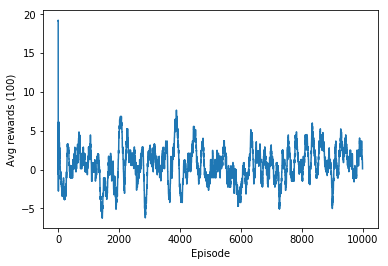

In [ ]:
plt.plot(all_avg_rewards)
plt.xlabel('Episode')
plt.ylabel('Avg rewards (100)')
plt.show()

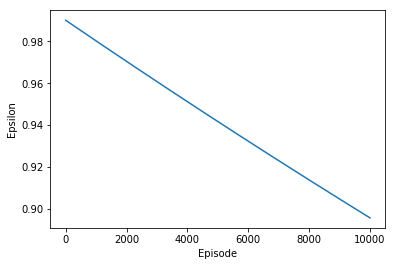

In [ ]:
plt.plot(all_epsilons)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.show()

<a class="anchor" id="save_weights"></a>
# Save weights
[Back to Table of Contents](#ToC)

- weightを保存

In [ ]:
TrainNet.save_weights('./weights.h5')

<a class="anchor" id="create_an_agent"></a>
# Create an agent
[Back to Table of Contents](#ToC)

- 得られた重みを文字列で保存

In [ ]:
fc_layers = []

# Get all hidden layers' weights
for i in range(len(hidden_units)):
    fc_layers.extend([
        TrainNet.model.hidden_layers[i].weights[0].numpy().tolist(), # weights
        TrainNet.model.hidden_layers[i].weights[1].numpy().tolist() # bias
    ])

# Get output layer's weights
fc_layers.extend([
    TrainNet.model.output_layer.weights[0].numpy().tolist(), # weights
    TrainNet.model.output_layer.weights[1].numpy().tolist() # bias
])

# Convert all layers into usable form before integrating to final agent
fc_layers = list(map(
    lambda x: str(list(np.round(x, precision))) \
        .replace('array(', '').replace(')', '') \
        .replace(' ', '') \
        .replace('\n', ''),
    fc_layers
))
fc_layers = np.reshape(fc_layers, (-1, 2))

In [ ]:
fc_layers.shape

(5, 2)

In [ ]:
# 例：最初の隠れ層の重み
fc_layers[0][0]

'[[0.0580333,0.0240042,-0.1154586,0.1551904,0.2306869,0.0660868,0.1352021,0.1233078,-0.1023744,0.0133442,0.2473091,0.1618967,0.2465961,0.1281778,0.1281388,-0.0381714,0.2420006,-0.2135146,0.1536522,0.1495576,0.2835534,0.1593349,0.2931632,0.0185692,0.1776966,-0.0675732,0.2592394,0.1970894,0.2553628,0.1661805,0.095641,0.205257,-0.1885213,0.1703794,0.0958127,0.1026047,0.1160222,0.0542527,0.2579578,0.0226066,-0.0221363,0.0672268,0.1618375,0.0196429,0.0358082,0.0813081,-0.0740104,0.2151837,-0.0525637,-0.1194441,-0.0877527,0.3056091,0.1300311,0.101513,0.106872,0.0230939,-0.0491901,0.0433491,0.1837129,0.0625183,0.1541195,0.2046533,0.117806,-0.0098331,-0.1301249,0.1744064,0.0471262,0.1652033,-0.1720918,0.4477519,0.1734292,-0.0987881,-0.0423112,0.2859856,0.2226159,-0.0507976,0.2958812,0.1991128,-0.0900785,0.3289235,0.1504927,0.1323886,0.2856707,0.1786754,0.143893,0.4375751,-0.1520022,0.2849642,0.0770939,0.1713488,0.2337194,-0.0645463,0.4614826,0.1081142,0.1335727,0.1404302,0.1770489,0.0543905,0.

 - エージェントを作る
 - submitは、エージェントの動きを定義する関数(my_agent)を文字列にした.pyの形で行う
 - my_agent：状態に合わせて、既に学習した層の重みを掛け合わせてQ値を算出し、Q値が最大になる行動を出力

In [ ]:
# Create the agent
my_agent = '''def my_agent(observation, configuration):
    import numpy as np

'''

# Write hidden layers
for i, (w, b) in enumerate(fc_layers[:-1]):
    my_agent += '    hl{}_w = np.array({}, dtype=np.float32)\n'.format(i+1, w)
    my_agent += '    hl{}_b = np.array({}, dtype=np.float32)\n'.format(i+1, b)
# Write output layer
my_agent += '    ol_w = np.array({}, dtype=np.float32)\n'.format(fc_layers[-1][0])
my_agent += '    ol_b = np.array({}, dtype=np.float32)\n'.format(fc_layers[-1][1])

my_agent += '''
    state = observation.board[:]
    state.append(observation.mark)
    out = np.array(state, dtype=np.float32)

'''

# Calculate hidden layers
for i in range(len(fc_layers[:-1])):
    my_agent += '    out = np.matmul(out, hl{0}_w) + hl{0}_b\n'.format(i+1)
    my_agent += '    out = 1/(1 + np.exp(-out))\n' # Sigmoid function
# Calculate output layer
my_agent += '    out = np.matmul(out, ol_w) + ol_b\n'

my_agent += '''
    for i in range(configuration.columns):
        if observation.board[i] != 0:
            out[i] = -1e7

    return int(np.argmax(out))
    '''

In [ ]:
with open('submission.py', 'w') as f:
    f.write(my_agent)

<a class="anchor" id="evaluate_the_agent"></a>
# Evaluate the agent
[Back to Table of Contents](#ToC)

In [ ]:
from submission import my_agent

- evaluate関数で他エージェントと戦わせた時の評価が確認可能

In [ ]:
def mean_reward(rewards):
    return sum(r[0] for r in rewards) / sum(r[0] + r[1] for r in rewards)

# Run multiple episodes to estimate agent's performance.
print("My Agent vs. Random Agent:", mean_reward(evaluate("connectx", [my_agent, "random"], num_episodes=10)))
print("My Agent vs. Negamax Agent:", mean_reward(evaluate("connectx", [my_agent, "negamax"], num_episodes=10)))
print("Random Agent vs. My Agent:", mean_reward(evaluate("connectx", ["random", my_agent], num_episodes=10)))
print("Negamax Agent vs. My Agent:", mean_reward(evaluate("connectx", ["negamax", my_agent], num_episodes=10)))

My Agent vs. Random Agent: 0.9
My Agent vs. Negamax Agent: 0.0
Random Agent vs. My Agent: 0.1
Negamax Agent vs. My Agent: 1.0
